# INTEGRATE Daugaard Case Study with geology-resistivity-category prior models.

This notebook contains an example of inversion of the DAUGAARD tTEM data using three different geology-resistivity prior models

In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # #%load_ext autoreload
    # # # # # # # #%autoreload 2
    pass

import integrate as ig
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True

import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

Notebook detected. Parallel processing is OK


## Download the data DAUGAARD data including non-trivial prior data

Getting data for case: DAUGAARD
--> Got data for case: DAUGAARD
<KeysViewHDF5 ['d_obs', 'd_std', 'i_hm', 'i_lm']>
Using hdf5 data file DAUGAARD_AVG_test.h5 with gex file TX07_20231016_2x4_RC20-33.gex


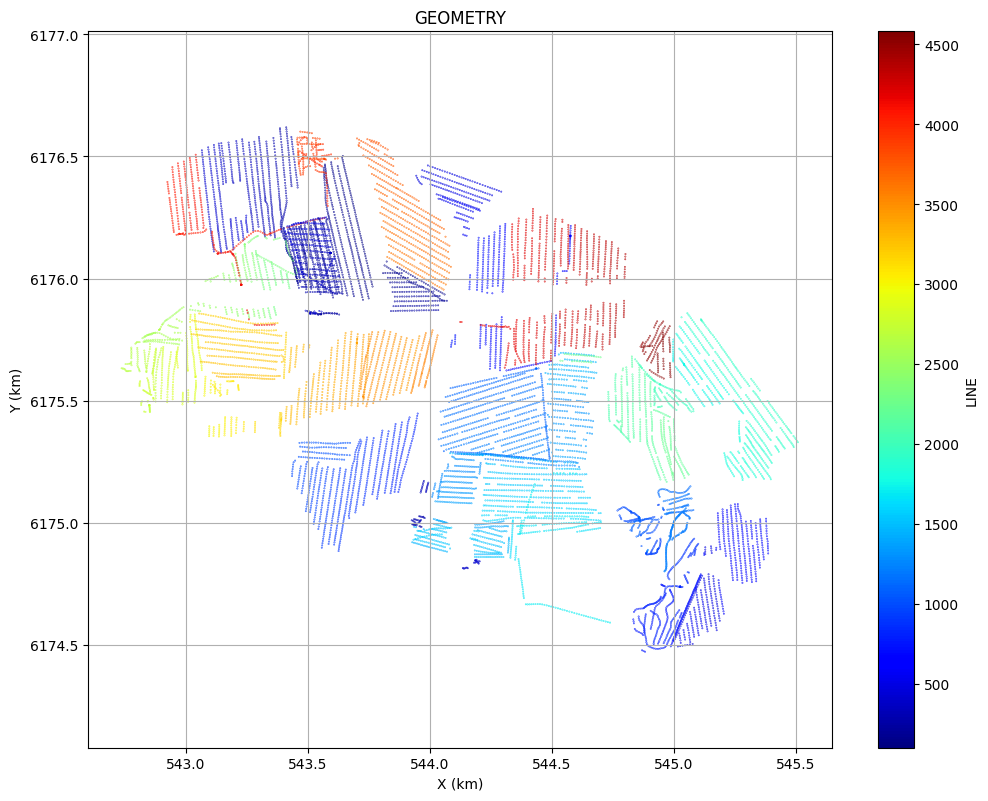

In [2]:
# For this case, we use a ready to use prior model and data set form DAUGAARD
files = ig.get_case_data(case='DAUGAARD', loadType='inout') # Load data and prior+data realizations
#files = ig.get_case_data(case='DAUGAARD', loadType='post') # # Load data and posterior realizations
#files = ig.get_case_data(case='DAUGAARD', loadAll=True) # All of the above
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)
# check that file_gex exists
if not os.path.isfile(file_gex):
    print("file_gex=%s does not exist in the current folder." % file_gex)


# make a copy using 'os' of  DAUGAARD_AVG.h5  DAUGAARD_AVG_test.h5 using the system
f_data_h5 = 'DAUGAARD_AVG_test.h5'
os.system('cp DAUGAARD_AVG.h5 %s' % (f_data_h5))

# Update and increase noise assumption
# Read 'D1/d_std' from f_data_h5, increase it by 100% and write it back to f_data_h5
with h5py.File(f_data_h5, 'a') as f:
    print(f['D1'].keys())
    d_std = f['D1/d_std'][:]
    d_std = d_std*10
    f['D1/d_std'][:] = d_std

print('Using hdf5 data file %s with gex file %s' % (f_data_h5,file_gex))

fig=ig.plot_data_xy(f_data_h5)

In [3]:
# Lets first make a small copy of the large data set available
f_prior_org_h5 = 'prior_detailed_inout_N4000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5'
N_small = 50000000000
f_prior_h5 = ig.copy_hdf5_file(f_prior_org_h5, 'prior_test.h5',N=N_small,showInfo=3)

print("Keys in DATA")
with h5py.File(f_data_h5, 'r') as f:
    print(f.keys()) 
    
print("Keys in PRIOR")
with h5py.File(f_prior_h5, 'r') as f:
    N = f['M1'].shape[0]
    print("N=%d" % N)
    print(f.keys()) 

Trying to copy prior_detailed_inout_N4000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5 to prior_test.h5
Copying D1
Loading D1 to memory


Copying D2
Loading D2 to memory
Copying M1
Loading M1 to memory


Copying M2
Loading M2 to memory


Copying M3
Loading M3 to memory
Keys in DATA
<KeysViewHDF5 ['D1', 'ELEVATION', 'LINE', 'UTMX', 'UTMY']>
Keys in PRIOR
N=4000000
<KeysViewHDF5 ['D1', 'D2', 'M1', 'M2', 'M3']>


Note how 2 types of prior data are available, but only one observed data!!

## Setting up the data and prior models
At this point we have a prior with 
three data types of  MODEL parameters
M1: Resistivity
M2: Lithology
M3: Scenario category [0,1]
## We have two types of corresponding data 
D1: tTEM data
D2: Scenario category [0,1]

D2 is simply an exact copy of, as D3=I*M3, where I is the identity operator.

This means, if som information is available about the Scenario type 
this can be provided as a new 'observation'

Here is an example of how this can be done

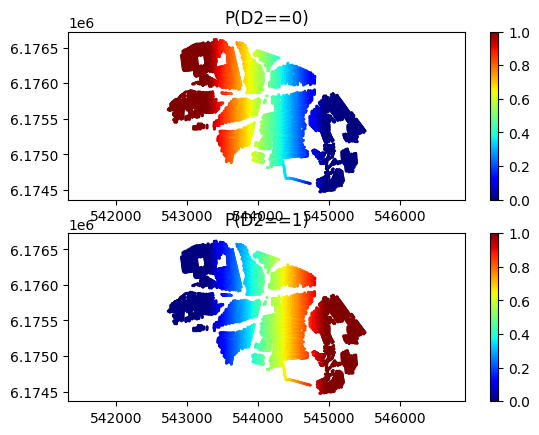

Trying to write D2 to DAUGAARD_AVG_test.h5


ValueError: not enough values to unpack (expected 3, got 2)

In [4]:
X, Y, LINE, ELEVATION = ig.get_geometry(f_data_h5)
Xmin = np.min(X)
Xmax = np.max(X)
Xl = Xmin + 0.2*(Xmax-Xmin)
Xr = Xmin + 0.8*(Xmax-Xmin)

P0 = 1# .9999 # Probability of category 0
Pcat0 = np.zeros(len(X))-1
for i in range(len(X)):
    if X[i] < Xl:
        Pcat0[i] = P0
    elif X[i] > Xr:
        Pcat0[i] = 1-P0
    else:
        #Pcat0[i] = .5
        Pcat0[i] = P0+(1-2*P0)*(X[i]-Xl)/(Xr-Xl)

nclasses = 2
D_obs = np.zeros((len(X),2))
D_obs[:,0] = Pcat0
D_obs[:,1] = 1-Pcat0

plt.figure()
for ic in range(nclasses):
    plt.subplot(2,1,ic+1)
    sc = plt.scatter(X, Y, c=D_obs[:,ic], cmap='jet', vmin=0, vmax=1, s=1)
    plt.colorbar(sc)
    plt.title('P(D2==%d)'%(ic))
    plt.axis('equal')
plt.show()

# ig.write_data_gaussian(f_data_h5, D_obs, 'D2', 'Scenario    )
# Now write the 'observed data as a new data type
# If the 'id' is not set, it will be set to the next available id
#ig.write_data_multinomial(D_obs, f_data_h5 = f_data_h5, showInfo=2)
# If the if is set, the data will be written to the given id, even if it allready exists
ig.write_data_multinomial(D_obs, id=2, f_data_h5 = f_data_h5, showInfo=2)



# Ready for inversion !!

In [5]:
print("Keys in DATA")
with h5py.File(f_data_h5, 'r') as f:
    print(f.keys()) 

Keys in DATA
<KeysViewHDF5 ['D1', 'ELEVATION', 'LINE', 'UTMX', 'UTMY']>


In [6]:
# identity copy of the prior model type for "Scenario", M3

Lets first add information directly about the scenario. 

In [7]:
id_use_arr = []
id_use_arr.append([2]) # Dicrete data
id_use_arr.append([1]) # tTEM data
id_use_arr.append([1,2]) # Both discrete and tTEM data

f_post_h5_arr = []
P0_mul = []

for i in range(len(id_use_arr)):

    id_use = id_use_arr[i]
    N_use = 100000
    updatePostStat =True
    f_post_h5 = ig.integrate_rejection(f_prior_h5, f_data_h5, 
                                    N_use = N_use, 
                                    parallel=parallel, 
                                    updatePostStat=updatePostStat, 
                                    showInfo=1,
                                    Ncpu=8,
                                    id_use = id_use)
    f_post_h5_arr.append(f_post_h5)

    #% 
    im=3 # Scenario Category
    with h5py.File(f_post_h5, 'r') as f:
        print("Keys in POSTERIOR")
        print(f['M3'].keys()) 
        post_MODE = f['M3/Mode'][:]
        post_P = f['M3/P'][:]
    
    P = post_P[:,:,0]
    P0_mul.append(P)


    plt.figure()
    for ic in range(nclasses):
        plt.subplot(2,1,ic+1)
        #sc = plt.scatter(X, Y, c=D_obs[:,ic], cmap='jet', vmin=0, vmax=1, s=20)
        sc = plt.scatter(X, Y, c=P[:,ic], cmap='jet', vmin=0, vmax=1, s=2)
        plt.colorbar(sc)
        plt.title('P(D2==%d)'%(ic))
        plt.axis('equal')
    plt.suptitle(' id_use=%s' % (id_use))
    plt.show()

    # ig.plot_profile(f_post_h5, im=2, i1=0, i2=1000)

Loaded data from DAUGAARD_AVG_test.h5
Data type 1: id_use=1,    gaussian, Using 11693/11693 data


KeyError: "Unable to synchronously open object (object 'D2' doesn't exist)"

In [8]:
n=len(f_post_h5_arr)
plt.figure(figsize=(8,1.5*n))
for i in range(n):
    plt.subplot(2,2,i+1)
    sc = plt.scatter(X/1000, Y/1000, c=P0_mul[i][:,0], cmap='jet', vmin=0, vmax=1, s=2)
    plt.colorbar(sc)
    plt.grid()
    plt.title('P(D2==%d)'%(ic))
    plt.axis('equal')
    # TIght axes
    plt.xlim([X.min()/1000,X.max()/1000])
    plt.ylim([Y.min()/1000,Y.max()/1000])
    plt.title('P(Inside Valley  | %s)' % (id_use_arr[i]))

    



<Figure size 800x0 with 0 Axes>